In [1]:
import pandas as pd
import geopandas as gpd 
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
from src.data_acquisition import fetch_pdok_buildings
import leafmap
import shapely
import folium
from shapely.geometry import box
import seaborn as sns 

## 1. Load Processed Data

In [2]:
buildings2 = gpd.read_file('../data/buildings_with_solar_analysis.json')
buildings2.columns

Index(['fid', 'b3_h_50p', 'b3_h_70p', 'b3_h_max', 'b3_h_min', 'b3_dd_id',
       'identificatie', 'b3_pand_deel_id', 'b3_bag_bag_overlap',
       'b3_n_vlakken', 'b3_pw_onvoldoende', 'b3_t_run', 'b3_h_nok', 'b3_n_nok',
       'b3_extrusie', 'b3_is_glas_dak', 'b3_dak_type', 'b3_h_maaiveld',
       'b3_kas_warenhuis', 'b3_mutatie_ahn3_ahn4', 'b3_mutatie_ahn4_ahn5',
       'b3_nodata_fractie_ahn3', 'b3_nodata_fractie_ahn4',
       'b3_nodata_fractie_ahn5', 'b3_nodata_radius_ahn3',
       'b3_nodata_radius_ahn4', 'b3_nodata_radius_ahn5', 'b3_opp_buitenmuur',
       'b3_opp_dak_plat', 'b3_opp_dak_schuin', 'b3_opp_grond',
       'b3_opp_scheidingsmuur', 'b3_puntdichtheid_ahn3',
       'b3_puntdichtheid_ahn4', 'b3_puntdichtheid_ahn5', 'b3_pw_bron',
       'b3_pw_datum', 'b3_pw_selectie_reden', 'b3_rmse_lod12', 'b3_rmse_lod13',
       'b3_rmse_lod22', 'b3_volume_lod12', 'b3_volume_lod13',
       'b3_volume_lod22', 'b3_bouwlagen', 'b3_kwaliteitsindicator',
       'begingeldigheid', 'documentdat

## create matplot Choropleth Map 

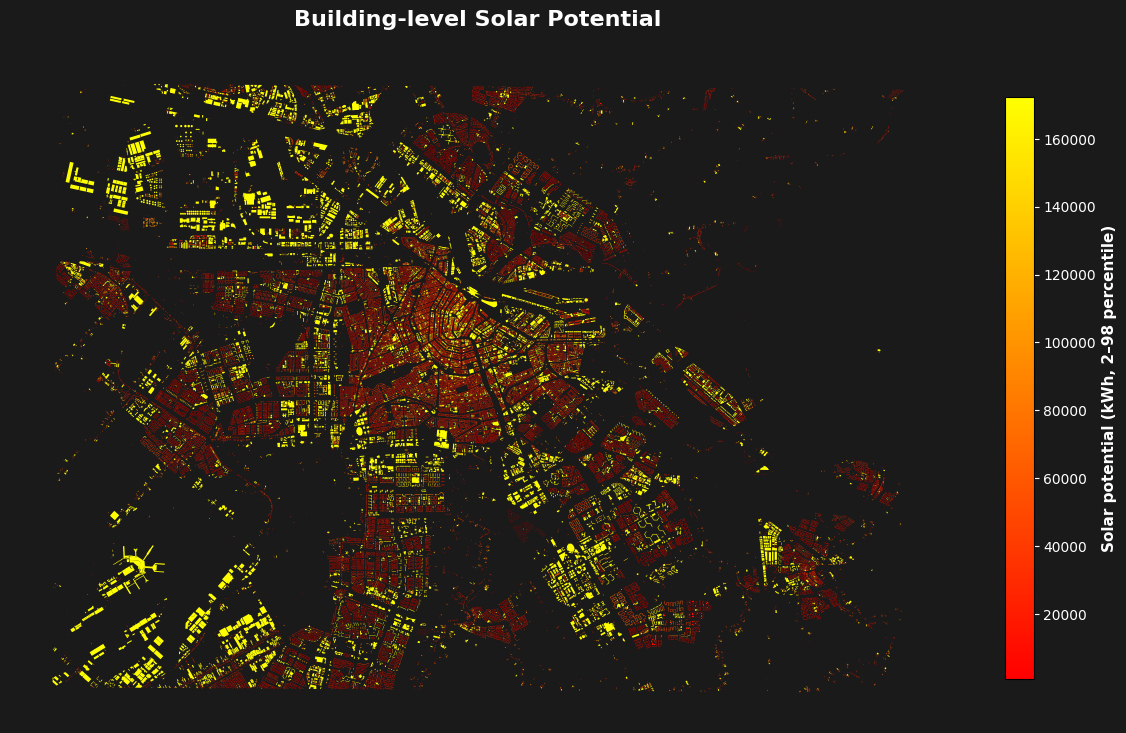

In [3]:


# -------------------------------------------------------------------
# 1. Select required columns
solar_potential = buildings2[
    ["solar_potential_kwh", "geometry"]
].copy()

# -------------------------------------------------------------------
# 2. Clean data
solar_potential = solar_potential.dropna(subset=["solar_potential_kwh"])
solar_potential = solar_potential[
    solar_potential["solar_potential_kwh"] > 0
]

# -------------------------------------------------------------------
# 3. Compute percentile limits
vmin = solar_potential["solar_potential_kwh"].quantile(0.02)
vmax = solar_potential["solar_potential_kwh"].quantile(0.98)

# -------------------------------------------------------------------
# 4. Create normalisation (clipped)
norm = Normalize(vmin=vmin, vmax=vmax, clip=True)

# -------------------------------------------------------------------
# 5. Plot with enhanced styling
fig, ax = plt.subplots(figsize=(12, 10), facecolor='#1a1a1a')

solar_potential.plot(
    column="solar_potential_kwh",
    cmap="autumn",
    linewidth=0,
    ax=ax,
    legend=True,
    norm=norm,
    legend_kwds={
        "label": "Solar potential (kWh, 2–98 percentile)",
        "shrink": 0.6,
        "pad": 0.05
    }
)

ax.set_facecolor('#0d0d0d') #black background

# Enhanced title styling
ax.set_title("Building-level Solar Potential", fontsize=16, fontweight='bold', color='white', pad=20)
ax.set_axis_off()

# Enhance legend readability
cbar = ax.get_figure().get_axes()[1]  # Get colorbar axis
cbar.tick_params(colors='white', labelsize=10)
cbar.yaxis.label.set_color('white')
cbar.yaxis.label.set_fontsize(11)
cbar.yaxis.label.set_fontweight('bold')

plt.tight_layout()
plt.show()


## 2. Interactive Map with Color-Coded Suitability

In [4]:

small_AOI_WGS = (4.857759,52.361683,4.872007,52.372013)

# Create a bounding box geometry from the AOI
aoi_box = box(*small_AOI_WGS)
aoi_gdf = gpd.GeoDataFrame(geometry=[aoi_box], crs="EPSG:4326")

# Ensure buildings2 is in the same CRS as AOI
buildings2_clipped = buildings2.to_crs("EPSG:4326")

# Clip buildings2 to the small_AOI
buildings2_clipped = gpd.clip(buildings2_clipped, aoi_gdf)

# Convert back to original CRS if needed (optional)
# buildings2_clipped = buildings2_clipped.to_crs(buildings2.crs)

print(f"Original buildings: {len(buildings2)}")
print(f"Clipped buildings: {len(buildings2_clipped)}")
print(f"AOI bounds: {aoi_box.bounds}")


Original buildings: 281608
Clipped buildings: 3150
AOI bounds: (4.857759, 52.361683, 4.872007, 52.372013)


In [5]:
buildings2_clipped.columns

Index(['fid', 'b3_h_50p', 'b3_h_70p', 'b3_h_max', 'b3_h_min', 'b3_dd_id',
       'identificatie', 'b3_pand_deel_id', 'b3_bag_bag_overlap',
       'b3_n_vlakken', 'b3_pw_onvoldoende', 'b3_t_run', 'b3_h_nok', 'b3_n_nok',
       'b3_extrusie', 'b3_is_glas_dak', 'b3_dak_type', 'b3_h_maaiveld',
       'b3_kas_warenhuis', 'b3_mutatie_ahn3_ahn4', 'b3_mutatie_ahn4_ahn5',
       'b3_nodata_fractie_ahn3', 'b3_nodata_fractie_ahn4',
       'b3_nodata_fractie_ahn5', 'b3_nodata_radius_ahn3',
       'b3_nodata_radius_ahn4', 'b3_nodata_radius_ahn5', 'b3_opp_buitenmuur',
       'b3_opp_dak_plat', 'b3_opp_dak_schuin', 'b3_opp_grond',
       'b3_opp_scheidingsmuur', 'b3_puntdichtheid_ahn3',
       'b3_puntdichtheid_ahn4', 'b3_puntdichtheid_ahn5', 'b3_pw_bron',
       'b3_pw_datum', 'b3_pw_selectie_reden', 'b3_rmse_lod12', 'b3_rmse_lod13',
       'b3_rmse_lod22', 'b3_volume_lod12', 'b3_volume_lod13',
       'b3_volume_lod22', 'b3_bouwlagen', 'b3_kwaliteitsindicator',
       'begingeldigheid', 'documentdat

## folium interactive map

In [6]:
# Filter buildings: remove NA and 0 values
buildings_for_map = buildings2_clipped[
    (buildings2_clipped['solar_potential_kwh'].notna()) & 
    (buildings2_clipped['solar_potential_kwh'] > 0)
].copy()

# Get center of the map
center_lat = buildings_for_map.geometry.centroid.y.mean()
center_lon = buildings_for_map.geometry.centroid.x.mean()

# Normalize solar potential for color mapping (0-1)
solar_min = buildings_for_map['solar_potential_kwh'].min()
solar_max = buildings_for_map['solar_potential_kwh'].max()

# Create folium map with satellite base
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=15,
    tiles='Esri.WorldImagery'
)

# Color function - gradient from yellow to dark red
def get_color(value, vmin, vmax):
    """Map value to color gradient based on min/max"""
    normalized = (value - vmin) / (vmax - vmin) if vmax > vmin else 0
    
    if normalized < 0.2:
        return '#FFFF00'  # Yellow
    elif normalized < 0.4:
        return '#FFA500'  # Orange
    elif normalized < 0.6:
        return '#FFD700'  # Gold
    elif normalized < 0.8:
        return '#FF6347'  # Tomato
    else:
        return '#8B0000'  # Dark Red

# Add building polygons to map with proper color mapping per building
for idx, row in buildings_for_map.iterrows():
    solar_kwh = row['solar_potential_kwh']
    color = get_color(solar_kwh, solar_min, solar_max)
    
    # Create GeoJson feature with color style
    folium.GeoJson(
        data={
            'type': 'Feature',
            'geometry': row.geometry.__geo_interface__,
            'properties': {'potential': solar_kwh}
        },
        style_function=lambda x, col=color: {
            'fillColor': col,
            'color': col,
            'weight': 1,
            'fillOpacity': 0.8
        },
        tooltip=f"Solar Potential: {solar_kwh:.1f} kWh"
    ).add_to(m)

# Save map to HTML file
output_file = '../outputs/solar_energy_map.html'
m.save(output_file)

# Display map
m


## 3. Pairwise Analysis Plots

In [11]:
# Filter out NA and 0 values
buildings_analysis = buildings2[
    (buildings2['solar_potential_kwh'].notna()) & 
    (buildings2['solar_potential_kwh'] > 0)
].copy()

print(f"Processing {len(buildings_analysis)} buildings...")

# -------------------------------------------------------------------
# 1. Create categorical classification based on quantiles
quantiles = buildings_analysis['solar_potential_kwh'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1.0])

def categorize_solar_potential(value):
    """Classify solar potential into 5 categories"""
    if value <= quantiles[0.2]:
        return 'Very Low'
    elif value <= quantiles[0.4]:
        return 'Low'
    elif value <= quantiles[0.6]:
        return 'Mid'
    elif value <= quantiles[0.8]:
        return 'High'
    else:
        return 'Very High'

# Apply categorization using vectorized operation
buildings_analysis['solar_category'] = buildings_analysis['solar_potential_kwh'].apply(categorize_solar_potential)

# -------------------------------------------------------------------
# 2. Create grouped analysis by solar category
# Define aggregation dictionary with specific columns
agg_dict = {
    'solar_potential_kwh': 'mean',
    'b3_dak_type': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],  # Most common type
    'roof_orientation_deg': 'mean',
    'b3_h_max': 'mean',
    'num_vertices': 'mean'
}

# Group by solar_category and apply aggregations
category_analysis = buildings_analysis.groupby('solar_category').agg(agg_dict).round(2)

# Reset index to make solar_category a column
category_analysis = category_analysis.reset_index()

# Reorder by category importance
category_order = ['Very Low', 'Low', 'Mid', 'High', 'Very High']
category_analysis['solar_category'] = pd.Categorical(category_analysis['solar_category'], 
                                                      categories=category_order, 
                                                      ordered=True)
category_analysis = category_analysis.sort_values('solar_category')

# Rename columns for clarity
category_analysis.columns = [
    'Solar Category',
    'Avg Solar Potential (kWh)',
    'Most Common Roof Type',
    'Avg Roof Orientation (°)',
    'Avg Max Height (m)',
    'Avg Num Vertices'
]

print("\n=== GROUPED ANALYSIS BY SOLAR CATEGORY ===")
print(category_analysis)
print(f"\nTotal Buildings: {len(buildings_analysis)}")


Processing 281608 buildings...

=== GROUPED ANALYSIS BY SOLAR CATEGORY ===
  Solar Category  Avg Solar Potential (kWh) Most Common Roof Type  \
4       Very Low                    1102.20            horizontal   
1            Low                    4527.80            horizontal   
2            Mid                    9574.80               slanted   
0           High                   13115.82               slanted   
3      Very High                   93147.53               slanted   

   Avg Roof Orientation (°)  Avg Max Height (m)  Avg Num Vertices  
4                    179.61                1.27              4.24  
1                    180.98                3.81              5.15  
2                    183.25                7.91              5.68  
0                    185.23               11.02              7.10  
3                    185.84               12.86             14.13  

Total Buildings: 281608


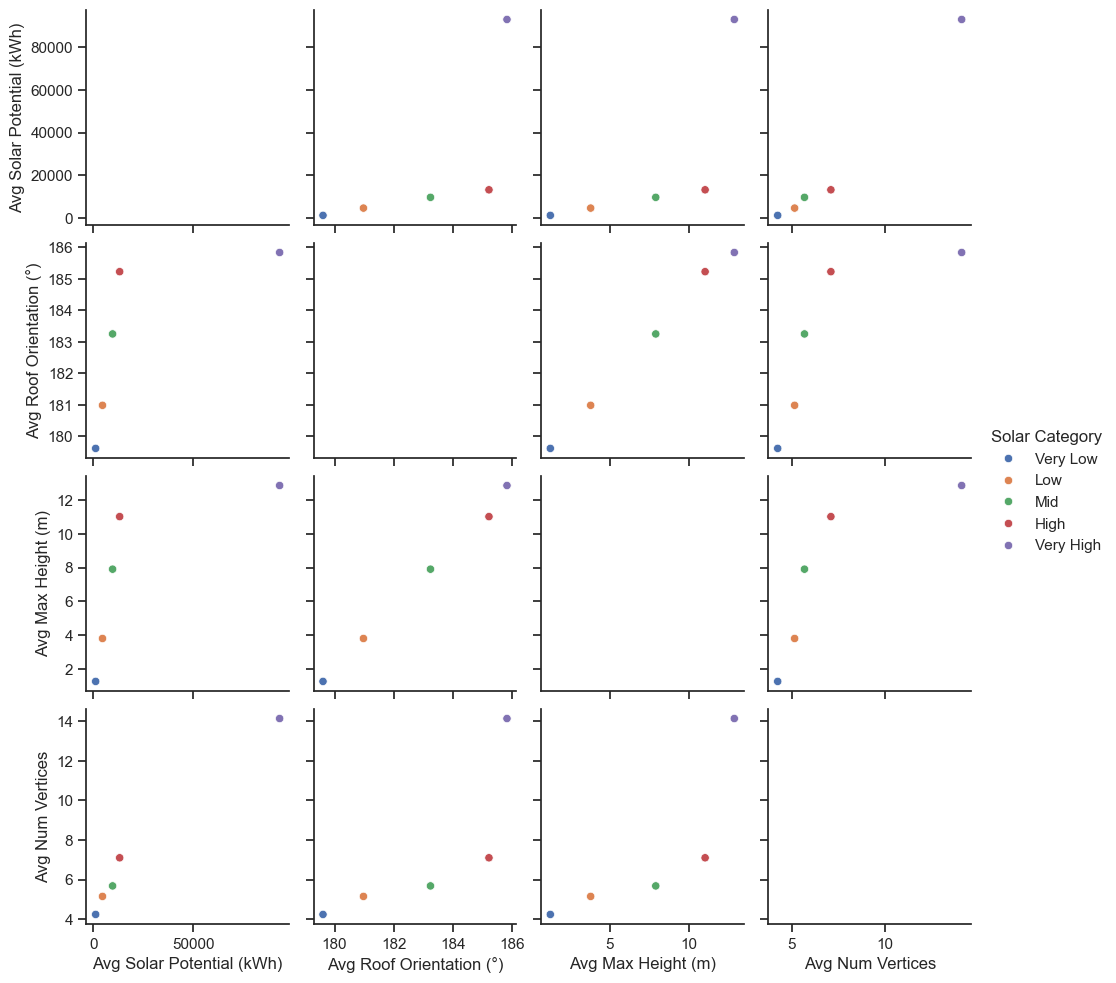

In [12]:
import seaborn as sns
sns.set_theme(style="ticks")


sns.pairplot(category_analysis, hue="Solar Category")

## 6. Top 100 Priority Buildings

In [13]:
# using spatial search module 
from src.spatial_search import find_top_k_buildings
top_100 =  find_top_k_buildings(buildings2, 100 , 'solar_potential_kwh')


In [14]:
# Convert to WGS84 if not already (folium requires EPSG:4326)
if top_100.crs != 'EPSG:4326':
    top_100_wgs84 = top_100.to_crs('EPSG:4326')
    print(f"Converted to: {top_100_wgs84.crs}")
else:
    top_100_wgs84 = top_100

# Get center of the map from top_100 data
center_lat = top_100_wgs84.geometry.centroid.y.mean()
center_lon = top_100_wgs84.geometry.centroid.x.mean()

print(f"Map center: ({center_lat}, {center_lon})")

# Create folium map with satellite base
m_top100 = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=15,
    tiles='Esri.WorldImagery'
)

# Add building polygons to map with simple red color
for idx, row in top_100_wgs84.iterrows():
    solar_kwh = row['solar_potential_kwh']
    
    folium.GeoJson(
        data={
            'type': 'Feature',
            'geometry': row.geometry.__geo_interface__,
        },
        style_function=lambda x: {
            'fillColor': '#FF0000',
            'color': '#FF0000',
            'weight': 1,
            'fillOpacity': 0.7
        },
        tooltip=f"Solar Potential: {solar_kwh:.1f} kWh"
    ).add_to(m_top100)

# Save map to HTML file
output_file_top100 = '../outputs/top_100_solar_buildings.html'
m_top100.save(output_file_top100)

m_top100


Converted to: EPSG:4326
Map center: (52.348367908711914, 4.810467512585507)


## Summary

### Generated Outputs:

1. **Interactive Map** - `outputs/suitability_map.html`
   - Color-coded buildings by suitability
   - Click for detailed building information

2. **Pairwise Analysis** - `outputs/pairwise_analysis.png`
   - Roof area vs. energy potential
   - Orientation vs. suitability
   - Shading factor effects

4. **Top 100 Buildings** - `outputs/top_100_buildings.html`
   - Priority ranking visualization


